# 今回の取り組み

## Nanoporeに最後まで読まれなかった（途中で切断された）リードがクラスタに分かれてしまうので、これを除去したい

- これはControlにも存在するはずだが、現状ではクラスラリングの際にControlにおいて切断リードの大半が含まれるであろうSVを無視しているため、差分が効いていない

- ✅ (1) SV判定をコンセンサスコールのあとにずらす
- **(2) クラスタリングの際にSampleとControlに同様に見られる切断リードを除く**

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, postprocess

#### #* 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/tyr_albino_50%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "single_tyr_50",
    "mm10",
    True,
    14,
)
print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single_tyr_50...


In [4]:

flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    print("preprocessing...")
    ################################################################################
    # Export fasta files as single-FASTA format
    ################################################################################
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    ###############################################################################
    # Mapping with mappy
    ###############################################################################
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    ########################################################################
    # MIDSV conversion
    ########################################################################
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    ###############################################################################
    # CSSPLITS Error Correction
    ###############################################################################
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    ###############################################################################
    # Convert any `N` as deletions other than consecutive `N` from both ends
    ###############################################################################
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_N_to_D.execute(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    ###############################################################################
    # Cashe inputs (control)
    ###############################################################################
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [6]:
MUTATION_LOCI = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)
####################################################################################
# Classify alleles
####################################################################################
print("Classify...")

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

# for classif in classif_sample:
#     classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

####################################################################################
# Clustering
####################################################################################
print("Clustering...")

clust_sample = clustering.clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI, THREADS)
clust_sample = clustering.clustering.add_readnum(clust_sample)
clust_sample = clustering.clustering.add_percent(clust_sample)
clust_sample = clustering.clustering.update_labels(clust_sample)


Classify...
Clustering...


In [9]:
count_labels = defaultdict(int)
for clust in clust_sample:
    count_labels[clust["LABEL"]] += 1

print(count_labels)

defaultdict(<class 'int'>, {1: 2489, 2: 2417, 3: 58, 4: 36})


In [10]:
####################################################################################
# Consensus call
####################################################################################
print("Consensus call...")

RESULT_SAMPLE, cons_percentage, cons_sequence = consensus.call(clust_sample, FASTA_ALLELES)


Consensus call...


KeyError: 'SV'

- consensus.callのあとに`SV`判定をしてみます

In [150]:
from __future__ import annotations

# from bisect import bisect_left
from collections import defaultdict
from itertools import groupby
import re


def call_percentage(cssplits: list[str]) -> list[dict[str, float]]:
    """
    Call position weight matrix in defferent loci.
    Non defferent loci are annotated to "Match" or "Unknown(N)"
    """
    cssplits_transposed = [list(cs) for cs in zip(*cssplits)]
    coverage = len(cssplits)
    cons_percentage = []
    for cs_transposed in cssplits_transposed:
        count_cs = defaultdict(int)
        for cs in cs_transposed:
            count_cs[cs] += 1 / coverage * 100
        count_cs_sorted = dict(sorted(count_cs.items(), key=lambda x: x[1], reverse=True))
        cons_percentage.append(count_cs_sorted)
    return cons_percentage


def call_sequence(cons_percentage: list[dict[str, float]]) -> str:
    consensus_sequence = []
    for cons_per in cons_percentage:
        cons = max(cons_per, key=cons_per.get)
        if cons.startswith("="):
            cons = cons.replace("=", "")
        elif cons.startswith("-"):
            continue
        elif cons.startswith("*"):
            cons = cons[-1]
        elif cons.startswith("+"):
            cons_ins = cons.split("|")
            if cons_ins[-1].startswith("="):
                cons = cons.replace("=", "")
            elif cons_ins[-1].startswith("-"):
                cons = "".join(cons_ins[:-1])
            elif cons_ins[-1].startswith("*"):
                cons = "".join([*cons_ins[:-1], cons_ins[-1][-1]])
            cons = cons.replace("+", "")
            cons = cons.replace("|", "")
        consensus_sequence.append(cons)
    return "".join(consensus_sequence)


def call_consensus(clust_sample: list[dict]) -> tuple[dict, dict]:
    cons_percentage = defaultdict(list)
    cons_sequence = defaultdict(list)
    clust_sample.sort(key=lambda x: x["LABEL"])
    for _, group in groupby(clust_sample, key=lambda x: x["LABEL"]):
        clust = list(group)
        keys = (
            clust[0]["ALLELE"],
            clust[0]["LABEL"],
            clust[0]["PERCENT"],
        )
        cssplits = [cs["CSSPLIT"].split(",") for cs in clust]
        cons_per = call_percentage(cssplits)
        cons_seq = call_sequence(cons_per)
        cons_percentage[keys] = cons_per
        cons_sequence[keys] = cons_seq
    return cons_percentage, cons_sequence


def _detect_sv(cons_sequence: dict, threshold: int = 50) -> list[bool]:
    exists_sv = []
    for seq in cons_sequence.values():
        if "N" * threshold in seq:
            exists_sv.append(True)
        elif re.search(rf"(\+[ACGTN]\|){{{threshold}}}", seq):
            exists_sv.append(True)
        elif re.search(rf"(\-[ACGTN]){{{threshold}}}", seq):
            exists_sv.append(True)
        elif re.search(rf"(\*[ACGTN][ACGTN]){{{threshold}}}", seq):
            exists_sv.append(True)
        elif re.search(r"[acgtn]", seq):
            exists_sv.append(True)
        else:
            exists_sv.append(False)
    return exists_sv


def call_allele_name(cons_sequence: dict, FASTA_ALLELES: dict) -> dict[int, str]:
    exists_sv = _detect_sv(cons_sequence)
    label_digits = len(str(len(cons_sequence)))
    allele_names = {}
    for is_sv, (keys, cons_seq) in zip(exists_sv, cons_sequence.items()):
        ALLELE, LABEL, PERCENT = keys
        label_format = f"{LABEL:0{label_digits}}"
        allele_name = f"allele{label_format}_{ALLELE}"
        if cons_seq == FASTA_ALLELES[ALLELE]:
            allele_name += "_intact"
        elif is_sv:
            allele_name += "_sv"
        else:
            allele_name += "_indels"
        allele_name += f"_{PERCENT}%"
        allele_names.update({LABEL: allele_name})
    return allele_names


def update_key_by_allele_name(cons: dict, allele_names: dict[int, str]) -> dict:
    for key, allele_name in zip(list(cons.keys()), allele_names.values()):
        cons[allele_name] = cons.pop(key)
    return cons

def add_key_by_allele_name(clust_sample: list[dict], allele_names: dict[int, str]) -> list[dict]:
    for clust in clust_sample:
        label = clust["LABEL"]
        clust["NAME"] = allele_names[label]
    return clust_sample



In [151]:
####################################################################################
# Consensus call
####################################################################################
print("Consensus call...")
cons_percentage, cons_sequence = call_consensus(clust_sample)

Consensus call...


In [152]:
print(cons_percentage.keys())
print(cons_sequence.keys())

dict_keys([('control', 1, 49.78), ('control', 2, 48.34), ('control', 3, 1.16), ('control', 4, 0.72)])
dict_keys([('control', 1, 49.78), ('control', 2, 48.34), ('control', 3, 1.16), ('control', 4, 0.72)])


In [153]:
allele_names = call_allele_name(cons_sequence, FASTA_ALLELES)
print(allele_names)

{1: 'allele1_control_intact_49.78%', 2: 'allele2_control_indels_48.34%', 3: 'allele3_control_sv_1.16%', 4: 'allele4_control_sv_0.72%'}


In [154]:
cons_percentage = update_key_by_allele_name(cons_percentage, allele_names)
cons_sequence = update_key_by_allele_name(cons_sequence, allele_names)

In [155]:
print(cons_percentage.keys())
print(cons_sequence.keys())

dict_keys(['allele1_control_intact_49.78%', 'allele2_control_indels_48.34%', 'allele3_control_sv_1.16%', 'allele4_control_sv_0.72%'])
dict_keys(['allele1_control_intact_49.78%', 'allele2_control_indels_48.34%', 'allele3_control_sv_1.16%', 'allele4_control_sv_0.72%'])


In [156]:
RESULT_SAMPLE = add_key_by_allele_name(clust_sample, allele_names)
RESULT_SAMPLE.sort(key=lambda x: x["LABEL"])

In [158]:
len(RESULT_SAMPLE)

5000

- 動作確認をします

In [ ]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01 DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

OK!

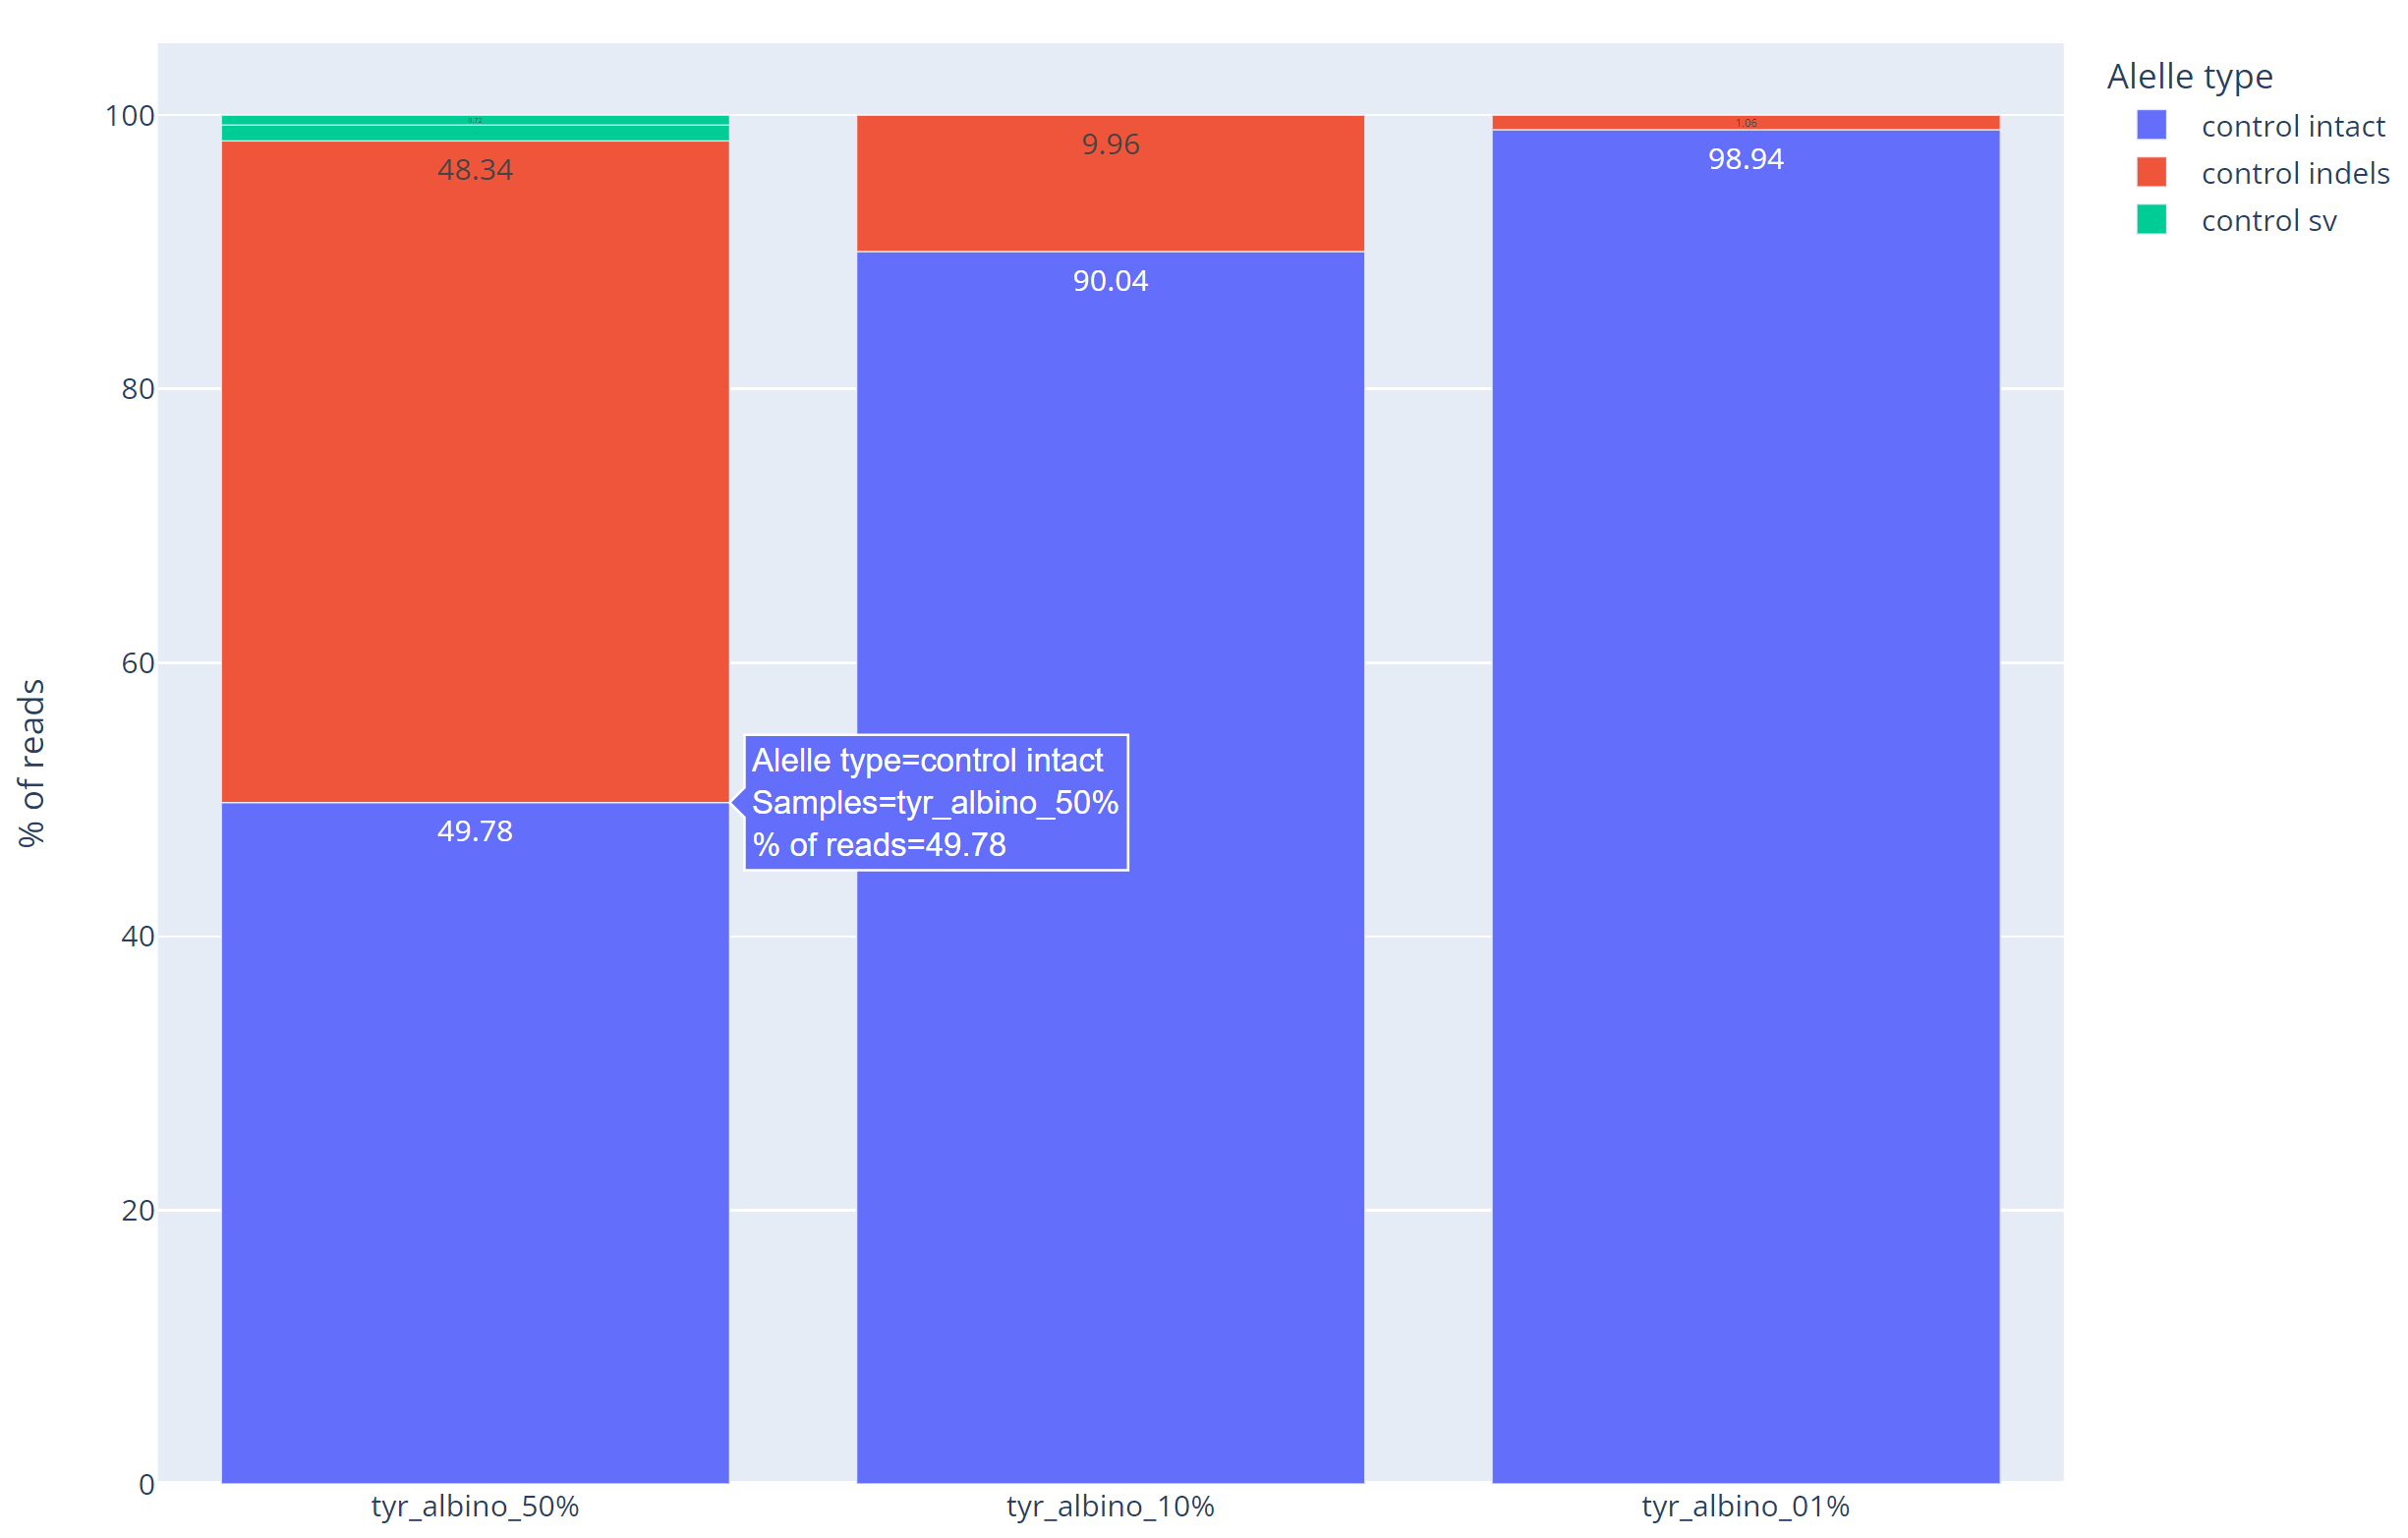

In [162]:
%%bash

rm -rf DAJINResults/single_tyr_50 DAJINResults/.tempdir/single_tyr_50 &&
time DAJIN2 \
    --name single_tyr_50 \
    --sample "misc/data/tyr_albino_50%.fq.gz" \
    --control "misc/data/tyr_control.fq.gz" \
    --allele "misc/data/tyr_control.fasta" \
    --genome mm10

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single_tyr_50 to see the report.

real	3m23.072s
user	3m29.077s
sys	2m22.375s


# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `consensus`全体の構造を見直し、モジュール結合性を弱めました
    - `consensus.call`を分割しました
    - コードが変更になっても各パーツごとに変更が用意になることを期待しています
    - 別の関数である`update_key_by_allele_name`と`add_key_by_allele_name`がallele_namesのデータ構造に依存しているのが少し気持ち悪いですが、本質ではないので無視します

- **Tyr 50% において、おそらくControlにもある断端リードが`SV`判定をされているのは消去したいところです**

# 次に取り組むこと

### Lists

- **Tyr 50% において、おそらくControlにもある断端リードが`SV`判定をされているのは消去したいところです**

+ ⬜ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
> + ⬜ cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`clustering.replace_both_ends_n`）
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする